In [1]:
#!pip install optuna
#!pip install jupyterlab-optuna
#!pip install optuna-fast-fanova gunicorn
#!pip install imbalanced-learn
#!pip install hyperopt
#!pip install lightgbm
#!pip install catboost
#!pip install optuna-integration

In [2]:
# Import standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import Scikit-learn modules  
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, log_loss, roc_auc_score, confusion_matrix, recall_score, average_precision_score

# Import display modules
from IPython.display import Markdown, display
from ipywidgets import widgets, Layout
from IPython import display as disp
from IPython.display import display, HTML


# Define a function for printing using markdown
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

#Bold text delimiters
start_bold = "\033[1m"
end_bold = "\033[0;0m"

# Import models
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
import lightgbm as lgb

# Import optimizers
import optuna
from optuna_integration import CatBoostPruningCallback
import warnings
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

In [3]:
#load the dataset and preview the first rows
df = pd.read_csv("./Data/diabetes.csv", sep = ",")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# EDA

In [4]:
#Verify that all columns have numeric types
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [5]:
#Check the target variable label values
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [6]:
#Get the summary sttistics for all the columns
display(round(df.describe(), 3))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


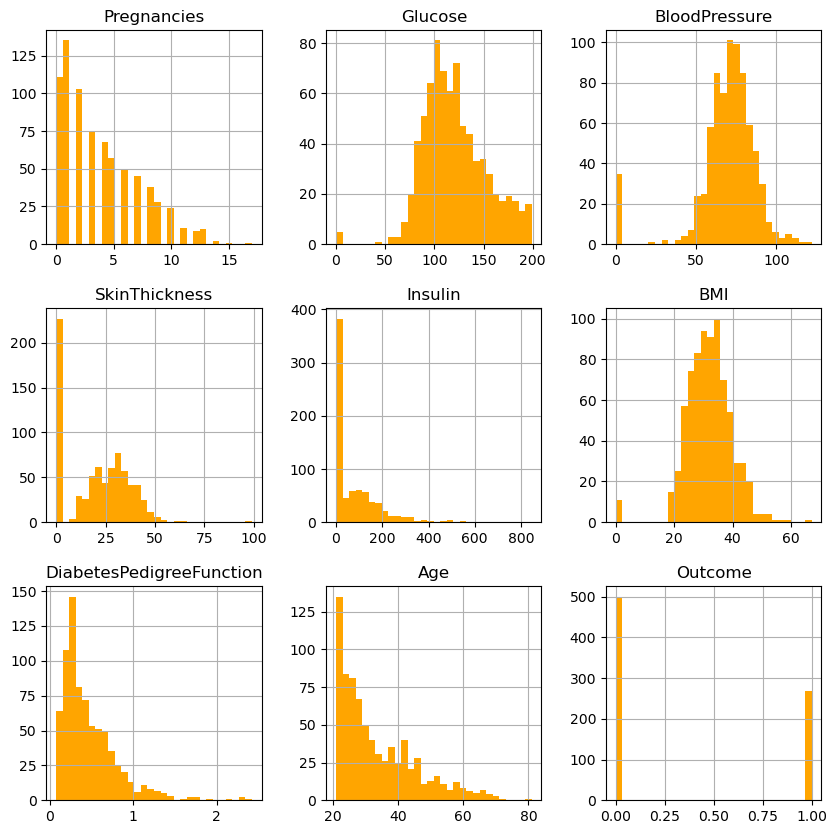

In [7]:
df.hist(bins = 30, figsize = (10, 10), color = 'orange')

plt.show()

Insights from the histograms:

* There are more young participants.
* Zero values for skin thickness, glucose, insulin, blood presure, and bmi indicate missing measurements. 
* There are about twice as many patients without diabetes (outcome = 0) than with diabetes (outcome = 1) resulting in imbalanced target classes.     

# Define helper functions

The following lines of code will be reused throughout the project and thus have been packed in a set of functions for easy access. 

In [8]:
# Define a function to extract information about missing measurements 
def print_missing_data_summary(df):
    '''
    This function will scan for missing values for different features and feature combinations at different steps of the imputation process.

    Symbol dicionary:
    
    N_GLU - Number of missing Glucose measurements 
    N_INS - Number of missing Insulin measurements
    N_BMI - Number of missing BMI measurements
    N_BPS - Number of missing Blood Pressure measurements
    N_STH - Number of missing Skin Thickness measurements     
    '''
    def printmd(string, color=None):
        colorstr = "<span style='color:{}'>{}</span>".format(color, string)
        display(Markdown(colorstr))  
    
    display(Markdown('---'))
    printmd(f"**N_GLU**: {df['Glucose'].isna().sum()}", color="#9DC183")
    printmd(f"**N_INS**: {df['Insulin'].isna().sum()}", color="#9DC183")
    printmd(f"**N_BMI**: {df['BMI'].isna().sum()}", color="#9DC183")
    printmd(f"**N_BPS**: {df['BloodPressure'].isna().sum()}", color="#9DC183")
    printmd(f"**N_STH**: {df['SkinThickness'].isna().sum()}", color="#9DC183")
    display(Markdown('---'))    

def render_widgets(num_widgets, titles, objects):
    # Create output widgets
    widgets_list = [widgets.Output() for _ in range(num_widgets)]
    
    # Render content in output widgets
    for i in range(num_widgets):
        with widgets_list[i]:
            # Display title in bold format
            title_html = "<b>{}</b>".format(titles[i])
            disp.display(disp.HTML(title_html))
            disp.display(objects[i])
    
    # Add CSS styles to distribute free space
    box_layout = Layout(display='flex',
                        flex_flow='row',
                        justify_content='flex-start',
                        width='auto'
                       )
    
    # Create Horizontal Box container
    hbox = widgets.HBox(widgets_list, layout=box_layout)
    
    # Render hbox
    disp.display(hbox)

from IPython.display import display, HTML

def render_static_widgets(num_widgets, titles, objects):
    # Create a string to hold the HTML content
    html_content = "<div style='display: flex;'>"
    
    # Add content for each widget
    for i in range(num_widgets):
        # Create a div for each widget
        html_content += "<div style='margin-right: 20px;'>"
        
        # Display title in bold format
        title_html = "<b>{}</b><br>".format(titles[i])
        html_content += title_html
        
        # Add object content
        html_content += objects[i]._repr_html_()
        
        # Close the div
        html_content += "</div>"
    
    # Close the flex container
    html_content += "</div>"
    
    # Create HTML widget with the combined content
    html_widget = HTML(html_content)
    
    # Display the HTML widget
    display(html_widget)

#Define a function to summarize the classification metrics
def print_classification_metrics(model, x_test, y_test, cm = True, return_metrics=False):
    
    # performance of the trained model using the testing set
    test_result = model.score(x_test, y_test)

    # make predictions on the test data
    y_predict = model.predict(x_test)

    # predict class probabilities on the test set
    y_predict_proba = model.predict_proba(x_test)
   
    # Calculate log loss for the test set
    log_loss_value = round(log_loss(y_test, y_predict_proba), 4)

    # Calculate ROC AUC for the test set    
    roc_auc = roc_auc_score(y_test, y_predict_proba[:, 1])

    # Define recall levels for interpolation
    recall_levels = np.linspace(0, 1, 100)
        
    # Calculate Precision-Recall score for the TEST set
    precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_predict_proba[:, 1])

    # Interpolate precision values for each recall level
    interp_precision_test = np.interp(recall_levels, recall_test[::-1], precision_test[::-1])

    # Calculate AUPRC using the trapezoidal rule
    auprc_test = np.trapz(interp_precision_test, recall_levels)
    
    #display test performance metrics
    test_report = pd.DataFrame(classification_report(y_test,
                                                     y_predict,
                                                     digits=4,
                                                     output_dict = True)).transpose().astype(float).round(4).map("{:,.2f}".format)    
    
    add_test_metrics = pd.DataFrame([{'Log Loss': np.round(log_loss_value, 2),
                                     'ROC AUC': np.round(roc_auc, 2),
                                     'AUPRC': np.round(auprc_test, 2)}], columns = ['Log Loss',
                                                                                 'ROC AUC',
                                                                                 'AUPRC']).transpose().rename(columns = {0: 'Score'})
    if return_metrics == False:
        titles = ['Performance report', 'Additional metrics']
        render_static_widgets(2, titles, [test_report, add_test_metrics]) 
    
    elif return_metrics == True:

        # Create a dictionary to store the metrics
        metrics_dict = {
            "test_report": test_report,
            "add_test_metrics": add_test_metrics
        }

        return metrics_dict  

    if cm == True:
        # Print the confusion matrix
        cm = confusion_matrix(y_test, y_predict)
            
        # Set the labels for the confusion matrix
        class_labels = ['Negative', 'Positive']  # Replace with your actual class labels
        
        # Create a heatmap with labels
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='RdGy', xticklabels=class_labels, yticklabels=class_labels)
        
        # Add labels and title
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        
        # Adjust the spacing between subplots
        plt.subplots_adjust(left=0.2, bottom=0.2)
        
        # Show the plot
        plt.show()

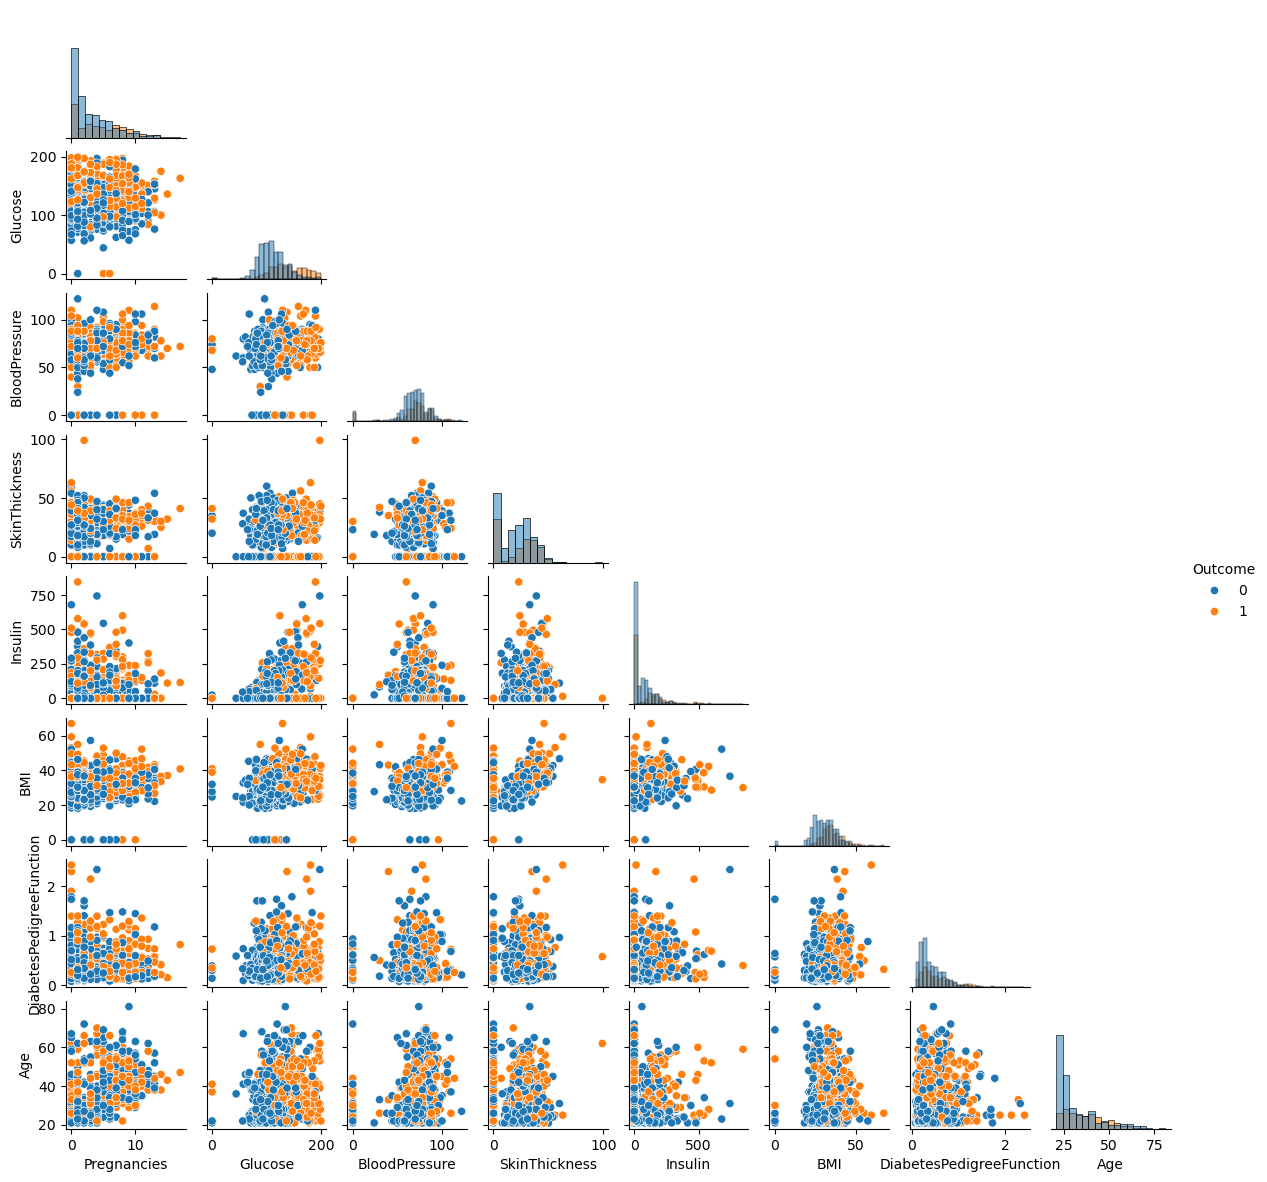

In [9]:
#display a pairplot to visualize correlations between feature pairs and feature distributions 
sns.pairplot(df, hue = 'Outcome', height = 1.5, corner = True, kind = 'scatter', diag_kind = 'hist')

In [10]:
cols = ["Glucose","Insulin","BMI","BloodPressure","SkinThickness"]
df[cols] = df[cols].replace({0: np.nan})

print_missing_data_summary(df)

---

<span style='color:#9DC183'>**N_GLU**: 5</span>

<span style='color:#9DC183'>**N_INS**: 374</span>

<span style='color:#9DC183'>**N_BMI**: 11</span>

<span style='color:#9DC183'>**N_BPS**: 35</span>

<span style='color:#9DC183'>**N_STH**: 227</span>

---

In [11]:
# split the dataframe into target and features

y = df["Outcome"].copy() # target
X = df.drop(columns = ["Outcome"]).copy() # features

# Verify that the split was performed correctly
print(X.shape)
print(y.shape)

(768, 8)
(768,)


In [12]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', copy = False)

cols = ["Glucose", "BMI", "BloodPressure"]
X[cols] = imp_mean.fit_transform(X[cols])

print_missing_data_summary(X)

---

<span style='color:#9DC183'>**N_GLU**: 0</span>

<span style='color:#9DC183'>**N_INS**: 374</span>

<span style='color:#9DC183'>**N_BMI**: 0</span>

<span style='color:#9DC183'>**N_BPS**: 0</span>

<span style='color:#9DC183'>**N_STH**: 227</span>

---

In [13]:
cols = ["Glucose", "Insulin"]

y_train_imp = X[cols[1]].dropna()
X_train_imp = X.loc[y_train_imp.index, cols[0]].values.reshape(-1, 1)

# Define the hyperparameter search space
space = {
    'depth': hp.quniform('depth', 2, 10, 1), 
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1001, dtype = int)),
    'learning_rate': hp.uniform('learning_rate', 0.0, 1.0),
    'max_leaves': hp.choice('max_leaves', np.arange(10, 65, dtype = int)),  
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0, 100),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'min_data_in_leaf': hp.uniform("min_data_in_leaf", 5, 100), 
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'random_strength': hp.quniform('random_strength', 1, 100, 1),
    }

# Define the objective function with early stopping
def catboost_objective(params):
    regressor = CatBoostRegressor(        
        objective = 'RMSE',        
        depth = int(params['depth']),
        iterations = int(params['n_estimators']),
        learning_rate = params['learning_rate'],
        max_leaves = int(params['max_leaves']),
        l2_leaf_reg = params['l2_leaf_reg'],
        colsample_bylevel = params['colsample_bylevel'],
        min_data_in_leaf = params['min_data_in_leaf'],
        subsample = params['subsample'],
        random_strength = int(params['random_strength']),        
        random_seed = 21,
        grow_policy = 'Lossguide',
        boosting_type = 'Plain',
        silent = True,
    )

    score = cross_val_score(regressor, 
                            X_train_imp,
                            y_train_imp, 
                            cv=5, 
                            scoring='neg_root_mean_squared_error',                             
                           )
    
    return {'loss': -score.mean(), 'status': STATUS_OK}
    
# Create a Trials object to track the optimization process
trials = Trials()

# Optimize the objective function using fmin
best = fmin(
    fn=catboost_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(21)
)

# Get the best hyperparameters
best_params = space_eval(space, best)

# Instantiate a Gradient Boosting Regressor with the best hyperparameters
gb_imputer = CatBoostRegressor(**best_params,
                           random_seed = 21,
                           grow_policy = 'Lossguide',
                           boosting_type = 'Plain',    
                           silent = True,                           
                           )

# Fit the imputer on your data
gb_imputer.fit(X_train_imp, y_train_imp)

y_missing_idx = X[cols[1]].isna()
X_new = X.loc[y_missing_idx, cols[0]].values.reshape(-1, 1)

# Predict missing values
y_predict = gb_imputer.predict(X_new)

# Update the original DataFrame with predicted values
X.loc[y_missing_idx, cols[1]] = y_predict

print_missing_data_summary(X)

100%|████████| 100/100 [02:48<00:00,  1.69s/trial, best loss: 98.01382213610191]


---

<span style='color:#9DC183'>**N_GLU**: 0</span>

<span style='color:#9DC183'>**N_INS**: 0</span>

<span style='color:#9DC183'>**N_BMI**: 0</span>

<span style='color:#9DC183'>**N_BPS**: 0</span>

<span style='color:#9DC183'>**N_STH**: 227</span>

---

In [14]:
cols = ["BMI", "SkinThickness"]

y_train_imp = X[cols[1]].dropna()
X_train_imp = X.loc[y_train_imp.index, cols[0]].values.reshape(-1, 1)

# Define the hyperparameter search space
space = {
    'depth': hp.quniform('depth', 2, 10, 1), 
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1001, dtype = int)),
    'learning_rate': hp.uniform('learning_rate', 0.0, 1.0),
    'max_leaves': hp.choice('max_leaves', np.arange(10, 65, dtype = int)),  
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0, 100),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'min_data_in_leaf': hp.uniform("min_data_in_leaf", 5, 100), 
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'random_strength': hp.quniform('random_strength', 1, 100, 1),
    }

# Define the objective function with early stopping
def catboost_objective(params):
    regressor = CatBoostRegressor(        
        objective = 'RMSE',        
        depth = int(params['depth']),
        iterations = int(params['n_estimators']),
        learning_rate = params['learning_rate'],
        max_leaves = int(params['max_leaves']),
        l2_leaf_reg = params['l2_leaf_reg'],
        colsample_bylevel = params['colsample_bylevel'],
        min_data_in_leaf = params['min_data_in_leaf'],
        subsample = params['subsample'],
        random_strength = int(params['random_strength']),        
        random_seed = 21,
        grow_policy = 'Lossguide',
        boosting_type = 'Plain',
        silent = True,
    )

    score = cross_val_score(regressor, 
                            X_train_imp,
                            y_train_imp, 
                            cv=5, 
                            scoring='neg_root_mean_squared_error',                             
                           )
    
    return {'loss': -score.mean(), 'status': STATUS_OK}
    
# Create a Trials object to track the optimization process
trials = Trials()

# Optimize the objective function using fmin
best = fmin(
    fn=catboost_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(21)
)

# Get the best hyperparameters
best_params = space_eval(space, best)

# Instantiate a Gradient Boosting Regressor with the best hyperparameters
gb_imputer = CatBoostRegressor(**best_params,
                           random_seed = 21,
                           grow_policy = 'Lossguide',
                           boosting_type = 'Plain',    
                           silent = True,                           
                           )

# Fit the imputer on your data
gb_imputer.fit(X_train_imp, y_train_imp)

y_missing_idx = X[cols[1]].isna()
X_new = X.loc[y_missing_idx, cols[0]].values.reshape(-1, 1)

# Predict missing values
y_predict = gb_imputer.predict(X_new)

# Update the original DataFrame with predicted values
X.loc[y_missing_idx, cols[1]] = y_predict

print_missing_data_summary(X)

100%|████████| 100/100 [02:58<00:00,  1.79s/trial, best loss: 7.877013425758325]


---

<span style='color:#9DC183'>**N_GLU**: 0</span>

<span style='color:#9DC183'>**N_INS**: 0</span>

<span style='color:#9DC183'>**N_BMI**: 0</span>

<span style='color:#9DC183'>**N_BPS**: 0</span>

<span style='color:#9DC183'>**N_STH**: 0</span>

---

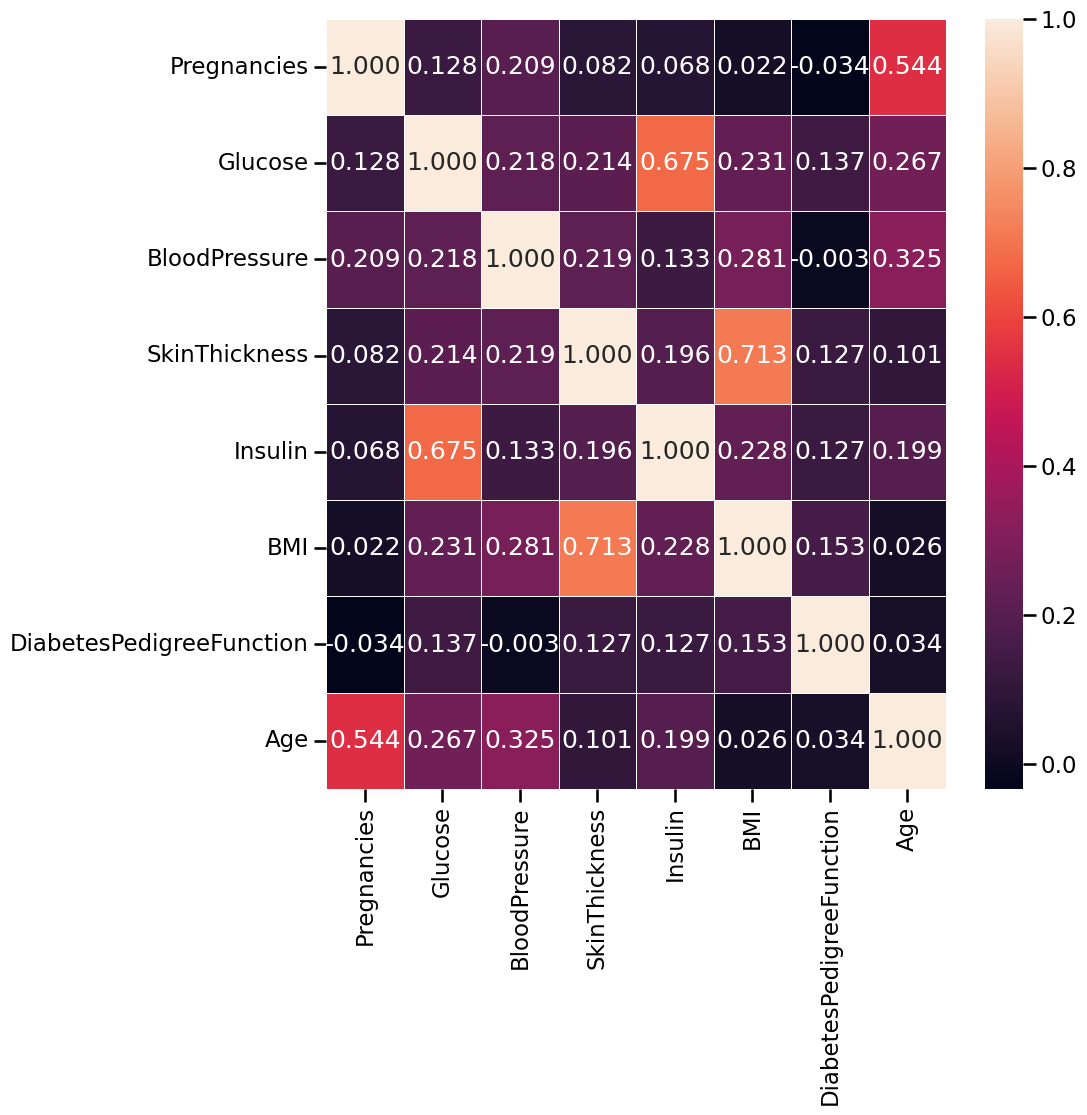

In [15]:
# Create a correlation matrix
corr_matrix = X.corr()

# Plot the correlation matrix
sns.set_context('talk')

plt.figure(figsize = (10, 10))

_ = sns.heatmap(corr_matrix, annot = True, fmt = ".3f", linewidths = .5)

plt.show()

In [16]:
df1 = df.dtypes.copy()
df2 = X.dtypes


titles = ['Original dtypes', 'New dtypes' ]
render_widgets(2, titles, [df1, df2])

In [17]:
cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'Age']

X[cols] = X[cols].astype(int)

X.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
dtype: object

In [18]:
from collections import Counter

counter = Counter(y)
print(counter)

Counter({0: 500, 1: 268})


In [19]:
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1.866


In [20]:
# split the labels and features into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 21, stratify = y)

# Verify that the split was performed correctly
print('Training set')
print(X_train.shape)
print(y_train.shape)
print()
print('Testing set')
print(X_test.shape)
print(y_test.shape)
print()

Training set
(514, 8)
(514,)

Testing set
(254, 8)
(254,)



In [21]:
# Verify that the index has been shuffled
print(X.index)
print()
print(X_train.index)

RangeIndex(start=0, stop=768, step=1)

Index([341, 695, 387, 528, 619, 195, 700, 581, 579, 131,
       ...
       570, 107, 588,   2, 355,  96, 544, 508, 470, 727],
      dtype='int64', length=514)


In [22]:
X_train.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [23]:
from sklearn.preprocessing import MinMaxScaler

# Create a StandardScaler object
scaler = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

# Transform the test data (using the same scaling parameters as the training data)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

display(pd.DataFrame(X_train_scaled).head())

print()

display(X_train.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.071429,0.271429,0.523810,0.152174,0.070913,0.154004,0.254056,0.250000
1,0.500000,0.607143,0.714286,0.184783,0.560096,0.246407,0.021349,0.366667
2,0.571429,0.342857,0.833333,0.315217,0.126202,0.511294,0.068745,0.400000
3,0.000000,0.428571,0.428571,0.260870,0.209135,0.254620,0.177199,0.016667
4,0.000000,0.442857,0.500000,0.228261,0.159856,0.287474,0.026900,0.050000


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
341,1,95,74,21,73,25.9,0.673,36
695,7,142,90,24,480,30.4,0.128,43
387,8,105,100,36,119,43.3,0.239,45
528,0,117,66,31,188,30.8,0.493,22
619,0,119,72,28,147,32.4,0.141,24


# Train a baseline XGBoost Classifier

In [24]:
#Build a classifier with minimum parameters
xgb_classifier = XGBClassifier(objective = 'binary:logistic', 
                               eval_metric = 'logloss',
                               scale_pos_weight = 1.866,
                               ).fit(X_train_scaled, y_train)

# Train a baseline model on the "raw" data

In [25]:
# Reload the unprocessed dataset
df_raw = pd.read_csv("./Data/diabetes.csv", sep = ",")

# split the unprocessed data into target and features

y_raw = df_raw["Outcome"] # target
X_raw = df_raw.drop(columns = ["Outcome"]) # features

# split the data into train and test sets
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size = 0.33, random_state = 21, stratify = y_raw)

#Build a classifier with minimum parameters
xgb_classifier_raw = XGBClassifier(objective = 'binary:logistic', 
                               eval_metric = 'logloss', 
                               scale_pos_weight = 1.866,
                               ).fit(X_train_raw, y_train_raw)

## Compare 

In [26]:
# Calculate the 
metrics_raw = print_classification_metrics(xgb_classifier_raw, X_test_raw, y_test_raw, return_metrics=True)

test_report_raw = metrics_raw['test_report']
add_metrics_raw = metrics_raw['add_test_metrics']

metrics_processed = print_classification_metrics(xgb_classifier, X_test_scaled, y_test, return_metrics=True)

test_report_processed = metrics_processed['test_report']
add_metrics_processed = metrics_processed['add_test_metrics']

titles = ['Raw report', 'Raw metrics', 'Processed report', 'Processed metrics']
render_static_widgets(4, titles, [test_report_raw, add_metrics_raw, test_report_processed, add_metrics_processed]) 

# Oversampling the minority class using SMOTE

In [27]:
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

sm = BorderlineSMOTE(sampling_strategy = 'minority',
           random_state = 21,
           k_neighbors = 8,
           )

X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

print()
print('Original dataset shape %s' % Counter(y_train))
print()
print('Resampled dataset shape %s' % Counter(y_res))
print()


Original dataset shape Counter({0: 335, 1: 179})

Resampled dataset shape Counter({0: 335, 1: 335})



In [28]:
#Build a classifier with minimum parameters
xgb_classifier = XGBClassifier(objective = 'binary:logistic', 
                               eval_metric = 'logloss',                            
                               ).fit(X_res, y_res)

# predict the performance score of the trained model using the testing dataset
print_classification_metrics(xgb_classifier, X_test_scaled, y_test, cm = False)

# Feature selection

In [46]:
selected_features = SelectKBest(chi2, k = 4).fit(X_res, y_res)

print('Score List: ', selected_features.scores_)
print()
print('Feature list: ', X_res.columns)

Score List:  [2.52449162 9.54712426 0.68026826 1.67765845 3.13455089 4.04781093
 2.64162968 4.46656397]

Feature list:  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')


In [47]:
X_train_best = pd.DataFrame(selected_features.transform(X_res))

X_test_best = pd.DataFrame(selected_features.transform(X_test_scaled))

display(X_train_best.head())
display(X_train_scaled.head())

,0,1,2,3
0,0.271429,0.070913,0.154004,0.250000
1,0.607143,0.560096,0.246407,0.366667
2,0.342857,0.126202,0.511294,0.400000
3,0.428571,0.209135,0.254620,0.016667
4,0.442857,0.159856,0.287474,0.050000


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.071429,0.271429,0.523810,0.152174,0.070913,0.154004,0.254056,0.250000
1,0.500000,0.607143,0.714286,0.184783,0.560096,0.246407,0.021349,0.366667
2,0.571429,0.342857,0.833333,0.315217,0.126202,0.511294,0.068745,0.400000
3,0.000000,0.428571,0.428571,0.260870,0.209135,0.254620,0.177199,0.016667
4,0.000000,0.442857,0.500000,0.228261,0.159856,0.287474,0.026900,0.050000


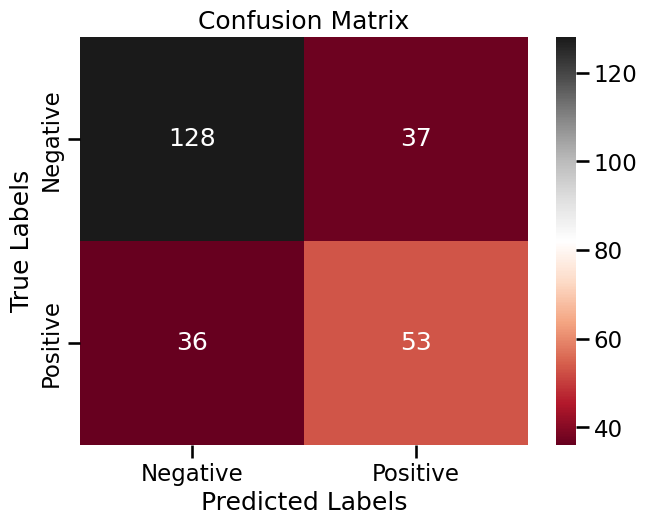

In [48]:
# Restore the original column names
X_train_best = X_train_best.rename(columns = {#0: 'Pregnancies', 
                                              0: 'Glucose',
                                              #2: 'SkinThickness',
                                              1: 'Insulin', 
                                              2: 'BMI', 
                                              #5: 'DPF', 
                                              3: 'Age',
                                             })
X_test_best = X_test_best.rename(columns = {#0: 'Pregnancies', 
                                            0: 'Glucose',
                                            #2: 'SkinThickness',
                                            1: 'Insulin', 
                                            2: 'BMI', 
                                            #5: 'DPF', 
                                            3: 'Age',
                                           })

#Build a classifier with minimum parameters
xgb_classifier = XGBClassifier(objective = 'binary:logistic', 
                               eval_metric = 'logloss',                                                           
                               )

#Fit the classifier to the raw data
xgb_classifier.fit(X_train_best, y_res)

# predict the performance score of the trained model using the testing dataset
print_classification_metrics(xgb_classifier, X_test_best, y_test)

# Optimizing the XGBoost classifier with optuna 

In [49]:
#Define the target parameters to be optimized
def objective(trial):    
    # Define the hyperparameter search space
    max_depth = trial.suggest_int('max_depth', 3, 10)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.0, 5e-1, log=False)
    max_leaves = trial.suggest_int('max_leaves', 0, 64)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)    
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.75, 1.95) 
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 100, log=False)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 100, log=False)
    eval_metric = trial.suggest_categorical("eval_metric", ['logloss',"error", "aucpr"])
     

    # Create the XGBClassifier with the sampled hyperparameters
    classifier = XGBClassifier(
        max_depth = max_depth,
        n_estimators = n_estimators,
        learning_rate = learning_rate,
        max_leaves = max_leaves,
        min_child_weight=min_child_weight,        
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        scale_pos_weight = scale_pos_weight,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,        
        eval_metric = eval_metric,
        objective = 'binary:logistic',        
        grow_policy = 'lossguide',        
        use_label_encoder = False,
        seed = 21,               
    )
    
    scores = cross_val_score(classifier, 
                             X_train_best, y_res,
                             cv=5,
                             scoring='neg_log_loss',
                             verbose = False,
                             )
    #return -scores.mean()
    return -scores.mean()

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Optimize the objective function
optuna.logging.set_verbosity(optuna.logging.WARNING)

study.optimize(objective, 
               n_trials=100, 
               timeout = 600, 
               show_progress_bar = True)

# Assign the best parameters
best_params = study.best_params

# Print the best hyperparameters and the corresponding score
print()
print('Best hyperparameters: ', pd.DataFrame([best_params]).transpose())
print()
print('Best score (Minimum loss): ', study.best_value)
print()

  0%|          | 0/100 [00:00<?, ?it/s]


Best hyperparameters:                            0
max_depth                 3
n_estimators            621
learning_rate      0.366428
max_leaves               50
min_child_weight          1
subsample          0.768211
colsample_bytree   0.500975
scale_pos_weight   1.805434
reg_alpha          4.324275
reg_lambda        27.293697
eval_metric           aucpr

Best score (Minimum loss):  0.5340411567304638



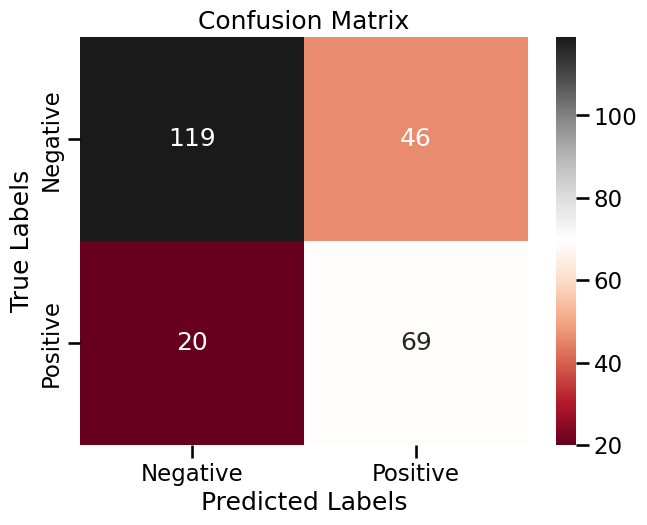

In [50]:
#Train an XGBoost classifier using the optimized parameters
xgb_classifier_opt = XGBClassifier(objective = 'binary:logistic',
                                   **best_params,                                   
                                   grow_policy = 'lossguide',
                                   use_label_encoder = False,
                                   seed = 21,
                                   ).fit(X_train_best, y_res, verbose = 0)

#Test the classifier on the test data
print_classification_metrics(xgb_classifier_opt, X_test_best, y_test)

# Optimize an XGBoost classifier using hyperopt

In [51]:
# Define the hyperparameter search space
space = {
    'max_depth': hp.choice('max_depth', np.arange(2, 11, dtype = int)), 
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1001, dtype = int)), 
    'learning_rate': hp.uniform('learning_rate', 1e-3, 5e-1),
    'max_leaves': hp.choice('max_leaves', np.arange(10, 65, dtype = int)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 11, dtype = int)),    
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1.75, 1.95),
    'reg_alpha': hp.uniform('reg_alpha', 1e-8, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 1e-8, 1.0),
}

# Define the objective function to optimize
def objective(params):
    classifier = XGBClassifier(
        max_depth = int(params['max_depth']),
        n_estimators = int(params['n_estimators']),
        learning_rate = params['learning_rate'],
        max_leaves = int(params['max_leaves']),
        min_child_weight = int(params['min_child_weight']),        
        subsample = params['subsample'],
        colsample_bytree = params['colsample_bytree'],
        scale_pos_weight = params['scale_pos_weight'],
        reg_alpha = params['reg_alpha'],
        reg_lambda = params['reg_lambda'],
        objective = 'binary:logistic',        
        use_label_encoder = False,
        seed = 21,        
    )

    score = cross_val_score(classifier, 
                            X_train_best, y_res, 
                            cv=5, 
                            scoring='neg_log_loss',                            
                           )
    
    return {'loss': -score.mean(), 'status': STATUS_OK}

# Create a Trials object to track the optimization process
trials = Trials()

# Optimize the objective function using fmin
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(21)
)

# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", pd.DataFrame([best]).transpose())
print()
print("Best score (Minimum loss):", trials.best_trial['result']['loss'])

100%|███████| 100/100 [03:04<00:00,  1.84s/trial, best loss: 0.5409014800038705]

Best hyperparameters:                            0
colsample_bytree    0.862315
learning_rate       0.046877
max_depth           8.000000
max_leaves         27.000000
min_child_weight    5.000000
n_estimators      322.000000
reg_alpha           0.145110
reg_lambda          0.319896
scale_pos_weight    1.874957
subsample           0.558753

Best score (Minimum loss): 0.5409014800038705


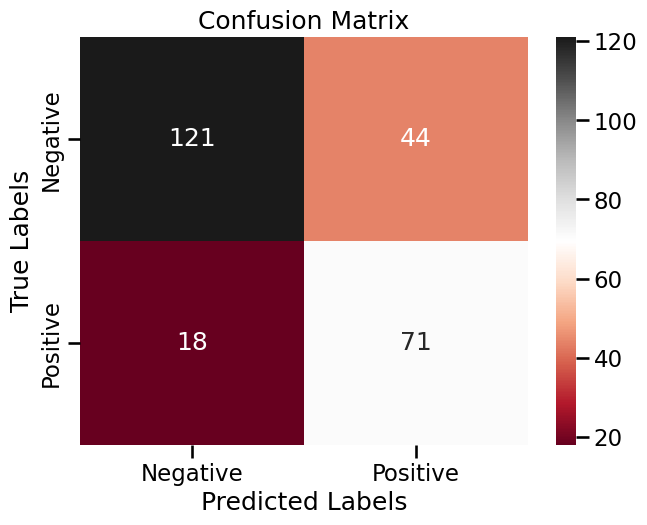

In [52]:
# Retrieve the best hyperparameters
best_params = space_eval(space, best)

# Train an XGBoost classifier using the optimized parameters
xgb_classifier_hyp = XGBClassifier(objective = 'binary:logistic',                                     
                                   **best_params,                                  
                                   use_label_encoder = False,
                                   seed = 21).fit(X_train_best, y_res, verbose = 0)

# Test the classifier using the test set
print_classification_metrics(xgb_classifier_hyp, X_test_best, y_test)

# Optimize a LightGBM model using optuna

In [53]:
# Define the objective function for LightGBM
def lgb_objective(trial):
    params = {        
        'objective': 'binary',        
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 64),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=False),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 11),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.75, 1.95),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=False),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=False),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 21,         
        'verbosity': -1,
    }

    scores = cross_val_score(lgb.LGBMClassifier(**params), 
                             X_train_best, y_res, 
                             cv=5, 
                             scoring='neg_log_loss',                              
                            )
    return -scores.mean()

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Optimize the objective function
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(lgb_objective, 
               n_trials=100, 
               timeout = 600, 
               show_progress_bar = True)

#Assign the best parameters
best_params = study.best_params

# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", pd.DataFrame([best_params]).transpose())
print()
print("Best score (Minimum loss):", study.best_value)
print()

  0%|          | 0/100 [00:00<?, ?it/s]


Best hyperparameters:                             0
max_depth            9.000000
num_leaves          32.000000
n_estimators       595.000000
learning_rate        0.017866
min_child_weight     5.000000
min_child_samples   41.000000
scale_pos_weight     1.814289
reg_alpha            0.960392
reg_lambda           0.051865
colsample_bytree     0.712700
subsample            0.520109

Best score (Minimum loss): 0.5347206129283427



# Train and test a LightGBM model using optimized hyperparameters

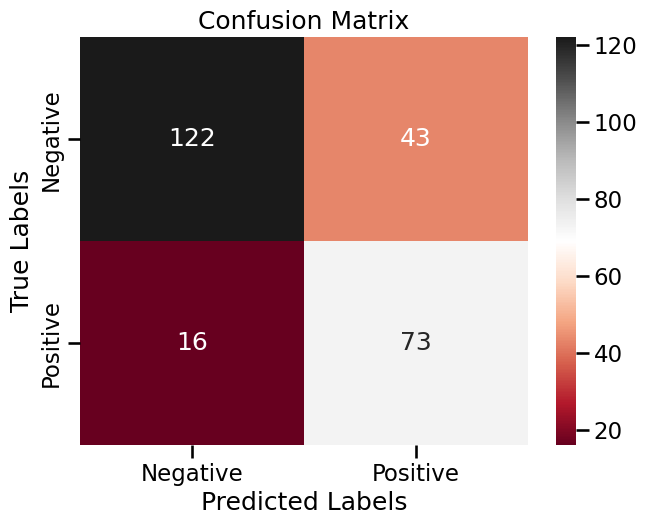

In [54]:
# Train the LightGBM model with the best hyperparameters
lgb_model = lgb.LGBMClassifier(**best_params,
                               verbosity = -1).fit(X_train_best, y_res)

#Test the model using the test set
print_classification_metrics(lgb_model, X_test_best, y_test)

# Optimize a LightGBM classifier using hyperopt

In [55]:
# Define the hyperparameter search space
space = {        
    'max_depth': hp.choice('max_depth', np.arange(2, 11, dtype = int)),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1001, dtype = int)),
    'learning_rate': hp.uniform('learning_rate', 1e-3, 5e-1),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 11, dtype = int)),
    'num_leaves': hp.choice('num_leaves', np.arange(10, 65, dtype = int)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'min_child_samples': hp.choice('min_child_samples', np.arange(5, 101, dtype = int)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1.75, 1.95),
    'reg_alpha': hp.uniform('reg_alpha', 1e-8, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 1e-8, 1.0),
}

# Define the objective function 
def objective(params):    
    classifier = lgb.LGBMClassifier(        
        objective = 'binary',
        max_depth = int(params['max_depth']),
        n_estimators = int(params['n_estimators']),
        learning_rate = params['learning_rate'],
        min_child_weight = int(params['min_child_weight']),        
        subsample = params['subsample'],
        colsample_bytree = params['colsample_bytree'],
        scale_pos_weight = params['scale_pos_weight'],
        reg_alpha = params['reg_alpha'],
        reg_lambda = params['reg_lambda'],                        
        seed = 21,        
        verbosity = -1,
    )

    # Cross validation
    score = cross_val_score(classifier, 
                            X_train_best, y_res, 
                            cv=5, 
                            scoring='neg_log_loss',                             
                           )
    
    return {'loss': -score.mean(), 'status': STATUS_OK}

# Create a Trials object to track the optimization process
trials = Trials()

# Optimize the objective function using fmin
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(21)
)

# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", pd.DataFrame([best]).transpose())
print()
print("Best score (Minimum loss):", trials.best_trial['result']['loss'])

100%|███████| 100/100 [01:45<00:00,  1.06s/trial, best loss: 0.5351702123810209]

Best hyperparameters:                            0
colsample_bytree    0.819682
learning_rate       0.038369
max_depth           4.000000
min_child_samples  41.000000
min_child_weight    2.000000
n_estimators       56.000000
num_leaves         29.000000
reg_alpha           0.850650
reg_lambda          0.666275
scale_pos_weight    1.889169
subsample           0.816112

Best score (Minimum loss): 0.5351702123810209


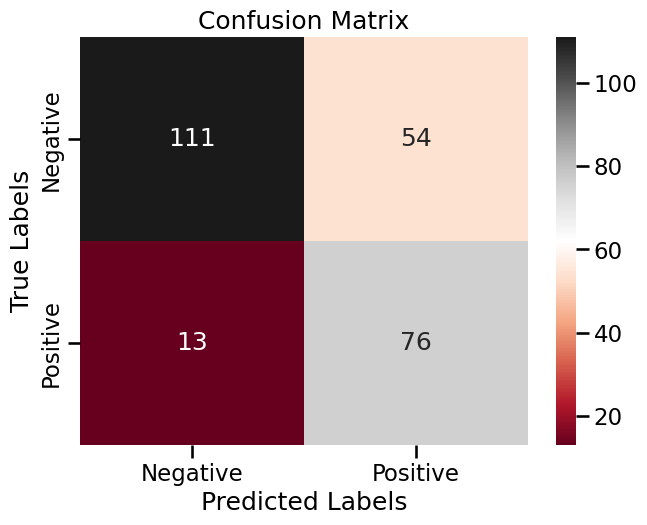

In [56]:
# Retrieve the best hyperparameters
best_params = space_eval(space, best)

#Train a classifier using the optimized parameters
lgb_classifier_hyp = lgb.LGBMClassifier(objective = 'binary',
                                        **best_params,                                                                             
                                        seed=21,                                        
                                        verbosity = -1).fit(X_train_best, y_res)

# Test the model using the test set        
print_classification_metrics(lgb_classifier_hyp, X_test_best, y_test)

# Optimize a CatBoost classifier using optuna 

In [64]:
# Define the objective function
def catboost_objective(trial):
    params = {
        'objective': 'Logloss',  
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'depth': trial.suggest_int('max_depth', 2, 10), 
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=False),        
        'num_leaves': trial.suggest_int('num_leaves', 10, 64),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.75, 1.95),  
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=False),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'random_strength': trial.suggest_int('random_strength', 1, 100),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0, log=False),
        'random_seed': 21,
        'grow_policy': 'Lossguide',
        'boosting_type': 'Plain',
        'used_ram_limit': '4gb',        
        'silent':True,
              
    }

    scores = cross_val_score(CatBoostClassifier(**params), 
                             X_res, y_res, 
                             cv=5, 
                             scoring='neg_log_loss',                             
                            )
    return -scores.mean()

    

# Create an Optuna study
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction='minimize')

# Optimize the objective function
optuna.logging.set_verbosity(optuna.logging.WARNING)

study.optimize(catboost_objective, 
               n_trials=100, 
               timeout=600, 
               show_progress_bar = True)

# Assign the best parameters
best_params = study.best_params

# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", pd.DataFrame([best_params]).transpose())
print()
print("Best score (Minimum loss):", study.best_value)
print()

  0%|          | 0/100 [00:00<?, ?it/s]


Best hyperparameters:                             0
colsample_bylevel    0.500546
max_depth            6.000000
learning_rate        0.049435
num_leaves          33.000000
min_data_in_leaf     6.000000
scale_pos_weight     1.935114
l2_leaf_reg         59.357487
n_estimators       704.000000
random_strength     55.000000
subsample            0.681719

Best score (Minimum loss): 0.4615128764719934



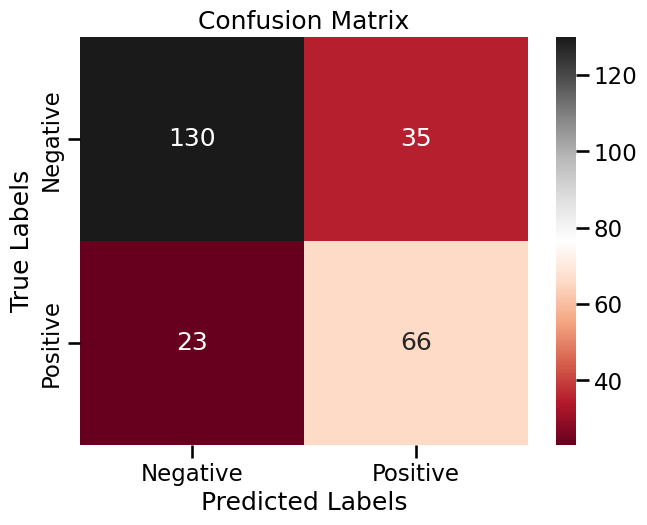

In [65]:
# Train the CatBoost model with the best hyperparameters
catboost_opt = CatBoostClassifier(objective = 'Logloss',
                                    **best_params,                                    
                                    grow_policy = 'Lossguide',
                                    silent = True,
                                    boosting_type = 'Plain',
                                    random_seed = 21,
                                   ).fit(X_res, y_res)

# Test the model using the test data
print_classification_metrics(catboost_opt, X_test_scaled, y_test)

# Optimize a CatBoost classifier using hyperopt

In [61]:
# Define the hyperparameter search space
space = {
    'depth': hp.quniform('depth', 2, 10, 1), 
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1001, dtype = int)),
    'learning_rate': hp.uniform('learning_rate', 0.0, 1.0),
    'max_leaves': hp.choice('max_leaves', np.arange(10, 65, dtype = int)),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1.75, 1.95),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0, 100),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'min_data_in_leaf': hp.uniform("min_data_in_leaf", 5, 100), 
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'random_strength': hp.quniform('random_strength', 1, 100, 1),
    }

# Define the objective function with early stopping
def catboost_objective(params):
    classifier = CatBoostClassifier(        
        objective = 'Logloss',        
        depth = int(params['depth']),
        iterations = int(params['n_estimators']),
        learning_rate = params['learning_rate'],
        max_leaves = int(params['max_leaves']),
        scale_pos_weight = params['scale_pos_weight'],
        l2_leaf_reg = params['l2_leaf_reg'],
        colsample_bylevel = params['colsample_bylevel'],
        min_data_in_leaf = params['min_data_in_leaf'],
        subsample = params['subsample'],
        random_strength = int(params['random_strength']),        
        random_state = 21,
        grow_policy = 'Lossguide',
        boosting_type = 'Plain',
        silent = True,
    )

    score = cross_val_score(classifier, 
                            X_res, y_res, 
                            cv=5, 
                            scoring='neg_log_loss',                             
                           )
    
    return {'loss': -score.mean(), 'status': STATUS_OK}
    
# Create a Trials object to track the optimization process
trials = Trials()

# Optimize the objective function using fmin
best = fmin(
    fn=catboost_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(21)
)

# Print the best hyperparameters and the corresponding score
print()
print("Best hyperparameters:", pd.DataFrame([best]).transpose())
print()
print("Best score:", trials.best_trial['result']['loss'])

100%|███████| 100/100 [09:24<00:00,  5.65s/trial, best loss: 0.4587896505054051]

Best hyperparameters:                             0
colsample_bylevel    0.508816
depth               10.000000
l2_leaf_reg         21.591426
learning_rate        0.062688
max_leaves          54.000000
min_data_in_leaf     5.409408
n_estimators       229.000000
random_strength      1.000000
scale_pos_weight     1.894729
subsample            0.909996

Best score: 0.4587896505054051


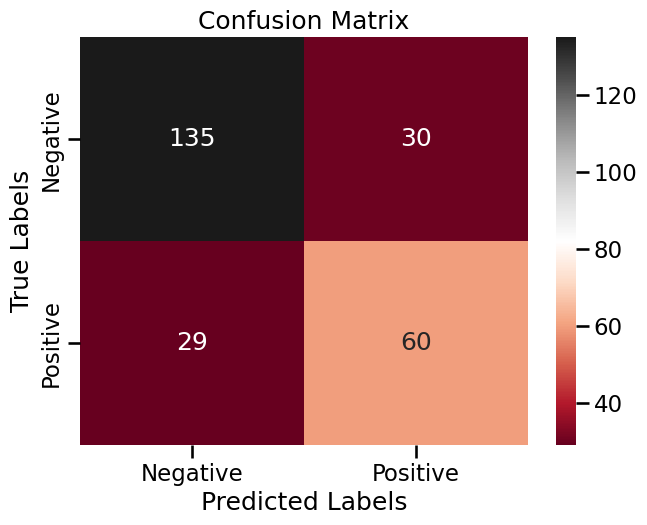

In [63]:
# Retrieve the best hyperparameters
best_params = space_eval(space, best)

# Create a new CatBoostClassifier instance with the best hyperparameters
catboost_hyp = CatBoostClassifier(
    objective='Logloss',
    **best_params,
    random_state=21,
    grow_policy = 'Lossguide',
    boosting_type = 'Plain',
    silent = True,      
).fit(X_res, y_res)

print_classification_metrics(catboost_hyp, X_test_scaled, y_test)